# Prerequisites

Import the following libraries for performing required operations and import the necessary functions

In [ ]:
%%capture
!pip install polars
!pip install tslearn
!pip install autoviz

In [ ]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import pandas as pd
from autoviz import AutoViz_Class
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

Imported v0.1.904. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Data Extraction

We are connecting to google drive to obtain the kaggle.json key value to access kaggle through our account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# from google.colab import files
# files.upload()

# Get the kaggle.json file form downloads

!sudo mkdir /root/.kaggle
!sudo cp '/content/drive/MyDrive/Important Keys/kaggle.json' /root/.kaggle/
!sudo chmod 600 /root/.kaggle/kaggle.json

Extract and save the datasets we need in colab 's temporary storage.

In [ ]:
%%capture
!kaggle datasets download arashnic/soalr-wind
!unzip /content/soalr-wind.zip -d /content/data
!rm /content/soalr-wind.zip

# Data Preprocessing & Visualization

## Functions

Actual dataset has DST values stored in the format

|timedelta|
|-------------------|
|"0 days 00:00:00"|
|"0 days 01:00:00"|
|"0 days 02:00:00"|
|$\cdots$|

This function converts all 'x days xx:xx:xx' format dates to datetime (microseconds) type conversion. The starting data 2016-01-01 is given in the dataset description as the starting datetime.

The timed gap between each reading here is 1 hour. Meaning every reading will be of form:

|timedelta|
|-------------------|
|2016-01-01 00:00:00|
|2016-01-01 01:00:00|
|2016-01-01 02:00:00|
|$\cdots$|

In [ ]:
def index_to_datetime(val):
    start_date = datetime.datetime(2016, 1, 1, 0, 0, 0)
    days, hours = int(val)//24, int(val)%24
    return start_date + datetime.timedelta(days=int(days), hours=hours)

In [ ]:
def convert_to_datetime(time_string):
    start_date = datetime.datetime(2016, 1, 1, 0, 0, 0)
    days, time_str = time_string.split(' days ')
    time_parts = time_str.split(':')
    hours, minutes, seconds = int(time_parts[0]), int(time_parts[1]), int(time_parts[2])
    return start_date + datetime.timedelta(days=int(days), hours=hours)

This function converts all 'x days xx:xx:xx' format dates to indices (int64) type conversion.

The timed gap between each reading here is 1 hour. Meaning every reading will be of form:

|timedelta|
|---------|
|0|
|1|
|2|
|$\cdots$|

In [ ]:
def convert_to_index(time_string):
    days, time_str = time_string.split(' days ')
    time_parts = time_str.split(':')
    hours, minutes, seconds = int(time_parts[0]), int(time_parts[1]), int(time_parts[2])
    return int(hours + int(days)*24)

## Labels (Dst)

This will be the labels part. Here we will have Distance Storm-time Index (DST index) values calculated for every hour. Period refers to the location from which a DST is calcualted. We have 3 locations here: _train_a_, _train_b_, and _train_c_.

In [ ]:
df = pl.read_csv('/content/data/labels.csv') #index_col = 'timedelta', dtypes={"period":pl.String}
df = df.with_columns(pl.col("timedelta").map_elements(convert_to_datetime))
df.sample(10)

This is the visualization of DST values over the time series model for every period.

In [ ]:
# title timedelta vs smoothed_ssn

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timedelta']
  ys = series['dst']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort("timedelta")
for i, (series_name, series) in enumerate(df_sorted.group_by('period')):
  _plot_series(series, series_name, i)
  fig.legend(title='period', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timedelta')
_ = plt.ylabel('smoothed_ssn')

Now we shall split all the periods into different dataframes using polars operations and frop the period table to avoid space consumption.

We shall also store the names of periods corresponding to the order in which the DST 's are stored in a seeprate list called _period_.

In [ ]:
sg_df = {}
period = []
for group, sub_df in df.group_by("period"):
    sg_df[group] = sub_df
    period.append(group)
del df, group, sub_df
for i in period:
    sg_df[i].drop_in_place("period")
    sg_df[i] = sg_df[i].sort("timedelta")
    print(i, sg_df[i].tail())

period.sort()
myKeys = list(sg_df.keys())
myKeys.sort()
sg_df = {i: sg_df[i] for i in myKeys}
sg_df

Extract both DST values and time series values in 2 seperate lists seperated by their respective periods. DST values are stored in _y_ and time series values are stored in _T_.

In [ ]:
y = []
for i in period:
    y.append(sg_df[i]['dst'])
    print(np.sort(np.asarray(sg_df[i]['dst'])))

T = []
for i in period:
    T.append(sg_df[i]['timedelta'])
    print(np.sort(np.asarray(sg_df[i]['timedelta'])))

Let 's visualize the peaks for all 3 periods through ACF and PACF to get a better understanding of the data.

In [ ]:
fig, axs = plt.subplots(len(y), 2, figsize=(12, 8))
for i in range(len(y)):
    plot_acf(y[i], lags=30, ax=axs[i,0])
    plot_pacf(y[i], lags=30, ax=axs[i,1])

    axs[i,0].set_title(f'DST \'{period[i]}\' (ACF)')
    axs[i,1].set_title(f'DST \'{period[i]}\' (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
Y = []
for i in range(len(period)):
    Y.append(pd.Series(y[i]))
    Y[i] = Y[i].set_axis(T[i])
Y

In [ ]:
del sg_df

## Solar Wind (Features)

In [ ]:
# %reset

In [ ]:
df = pl.read_csv('/content/data/solar_wind.csv')
df.drop_in_place("source")
df = df.with_columns(pl.col("timedelta").map_elements(convert_to_index))

Let us visualize only the columns with <1,000 unique values.

In [ ]:
for i in df.columns:
    f = df[i].value_counts()
    if len(f) < 1_000:
        print(i, f)
    del f

It turns out that only period satisfies the condition. Meaning we can assume that other values are distributed on a continous scale.

To get more insight lets get the descrption of each and every column.

In [ ]:
df.describe()

Since we found lot of missing values we are extracting the count of each column 's missing values here.

In [ ]:
df_len = len(df[df.columns[0]])
df_len

In [ ]:
missing = list(zip(list(df.columns), list((df.null_count()).row(0))))
missing

We are removing columns with more than a 1/20th of missing values.

In [ ]:
for i in missing:
    if i[1] >= (df_len/20):
        df.drop_in_place(i[0])

Fill the missing values through forward method. Forward method fills the missing value based on what is there after the missing value. Other such methods include ['forward', 'backward', 'mean'] which we can use.

In [ ]:
df = df.with_columns(
    pl.all().fill_null(strategy="forward")
)

In [ ]:
df.describe()

For the purpose of data visualization we are saving the updated dataframe as a new CSV file and saving it as X.

In [ ]:
df.write_csv('/content/data/X.csv', separator=",")

Following is the possible meaningful visualizations for the above dataframe.

In [ ]:
AV = AutoViz_Class()

filename = '/content/data/X.csv'
# depVar = 'medv'
# sep=','

_ = AV.AutoViz(filename)

We are dropping the following columns due to high correlation (meaning high dependency) with existing columns.

In [ ]:
df.drop_in_place('bx_gsm')
df.drop_in_place('by_gsm')
df.drop_in_place('bz_gsm')
df.drop_in_place('phi_gsm')
df.drop_in_place('theta_gsm')

Correlation coefficient matrix of the entire dataframe. Every number marked represents the columns in order.

In [ ]:
corr_coefficient_matrix = df.select(pl.exclude(["period", "timedelta"])).corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_coefficient_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Feature Correlation Coefficient Matrix')
plt.show()

group_by("timedelta") is used to group all timedelta values with same exact time. This is why we didnt add minutes and seconds to the convert_to_timedelta or convert_to_index function.

Then we arrange them in ascending order of timedelta.

In [ ]:
sg_df = list(df.group_by("period"))
x = {}
for i in sg_df:
    x[i[0]] = i[1].group_by("timedelta").agg(pl.col(list(df.columns[2:])).mean())

myKeys = list(x.keys())
myKeys.sort()
x = {i: x[i] for i in myKeys}

for i in sg_df:
    x[i[0]] = x[i[0]].sort("timedelta")
x

In [ ]:
X = dict()

for i, key in enumerate(x.keys()):
    X[key] = x[key].to_pandas()
    X[key].index = pd.Series(T[i])
    X[key] = X[key].drop('timedelta', axis=1)
X

In [ ]:
del sg_df, df, myKeys, _, missing, AV, df_len, x

## Sunspots (Wolf number)

Sunspots are the no. of spots observed from a location (period) at time t.

In [ ]:
df = pl.read_csv('/content/data/sunspots.csv')
df = df.with_columns(pl.col("timedelta").apply(convert_to_datetime))
df.sample(6)
# np.asarray(df['smoothed_ssn'])

In [ ]:
# title timedelta vs smoothed_ssn

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timedelta']
  ys = series['smoothed_ssn']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort("timedelta")
for i, (series_name, series) in enumerate(df_sorted.group_by('period')):
  _plot_series(series, series_name, i)
  fig.legend(title='period', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timedelta')
_ = plt.ylabel('smoothed_ssn')

In [ ]:
df.describe()

In [ ]:
del df, ax, _, fig

# Time Series Modelling

In [ ]:
for i in range(len(period)):
    model = SARIMAX(pd.Series(Y[i]), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    result = model.fit()
    forecast = result.forecast(steps=12)
    plt.figure(figsize=(14, 10), dpi=120)
    plt.plot(pd.Series(Y[i]))
    plt.plot(forecast)
    plt.show()
    del result, model, forecast

In [ ]:
llf_vals = dict()
lag_val = []
avg_VAR = 0.0
for i in period:
    model = VAR(X[i][:1000])
    sorted_order = model.select_order(maxlags=50)
    lag_val.append(sorted_order.aic.min())

    results = model.fit(maxlags=sorted_order.aic.min(), ic='aic')
    llf_vals[i] = results.llf
    print(f'Log Likelihood for {i}: {llf_vals[i]}')
    avg_VAR += llf_vals[i]

avg_VAR /= len(period)
print(f"Average Log Likelihood {avg_VAR}")

In [ ]:
res = dict()

for i, key in enumerate(X.keys()):
    model = sm.tsa.VARMAX(X[key][:500], order=(1,1)) # order=(lag_val[i],50-lag_val[i]))
    res[i] = model.fit(maxiter=1000, disp=False)
    print(res[i].summary())

Using these above results, we can predict variables for the given timedelta (time period) which can be used for predicting DST value. Examples of such models we can use for predicting DST are MAP (Maxima a posteriori), GAN (Generative Adversial Networks), HMM (Hidden Markov Models) and other such Generative ML models.

# Regressive Machine Learning

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

LinReg = []
print("L0inear Regression Scores\n")

for i, key in enumerate(X.keys()):
    X_train, X_test, y_train, y_test = train_test_split(X[key],Y[i],random_state=104,test_size=0.25,shuffle=True)
    LinReg.append(LinearRegression())
    LinReg[i].fit(X_train, y_train)
    #print(list(zip(LinReg[i].predict(X_test), y_test)))
    print(f'{key} - {round(100*LinReg[i].score(X_test, y_test),6)}%')

L0inear Regression Scores

train_a - 15.125987%
train_b - 10.565174%
train_c - 10.543494%


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

PolyReg = []
print("Polynomial Regression Scores\n")

for i, key in enumerate(X.keys()):
    X_train, X_test, y_train, y_test = train_test_split(X[key],Y[i],random_state=104,test_size=0.25,shuffle=True)
    PolyReg.append(PolynomialFeatures(degree=2, include_bias=False))
    PolyReg[i].fit_transform(X_train, y_train)
    lin2 = LinearRegression()
    lin2.fit(X_train, y_train)
    y_pred = PolyReg[i].transform(X_test)
    print(y_pred, y_test.shape, y_pred.shape)
    #rms = mean_squared_error(y_test, y_pred, squared=False)

Polynomial Regression Scores

[[-8.53000000e+00 -1.70000000e+00  1.52000000e+00 ...  3.65918641e+04
   1.68909070e+03  7.79689000e+01]
 [-4.31966667e+00  3.31883333e+00 -1.25000000e-01 ...  2.01790075e+04
   8.39248139e+02  3.49044640e+01]
 [-1.44500000e-01 -3.87900000e+00 -8.66333333e-01 ...  7.24284450e+04
   1.23093442e+03  2.09199514e+01]
 ...
 [-3.11100000e+00  3.24333333e+00  3.08750000e+00 ...  1.82305354e+04
   8.01256654e+02  3.52163121e+01]
 [-6.89700000e+00  3.01883333e+00  2.74333333e-01 ...  2.44569459e+04
   1.19659641e+03  5.85454523e+01]
 [-9.67666667e-01  4.59650000e+00  2.37616667e+00 ...  1.01894556e+04
   5.65414457e+02  3.13749351e+01]] (7206,) (7206, 27)
[[ 4.66800000e+00 -5.61483333e+00  4.17500000e+00 ...  9.57829253e+04
   2.64994085e+03  7.33135521e+01]
 [ 1.09416667e+00 -9.91333333e-01 -5.17666667e-01 ...  1.00777994e+05
   5.06394432e+02  2.54455669e+00]
 [ 1.49250000e+00 -4.69800000e+00 -1.22300000e+00 ...  8.26254904e+04
   1.50780062e+03  2.75152702e+01]


[(array([5.48813504, 3.11795882]), [3.310087591609415]), (array([7.15189366, 6.96343489]), [1.6392685014813946]), (array([6.02763376, 3.77751839]), [4.833562954578343]), (array([5.44883183, 1.79603678]), [4.933985104124673]), (array([4.23654799, 0.24678728]), [7.774698269400762]), (array([6.45894113, 0.67249631]), [5.28439483527963]), (array([4.37587211, 6.79392773]), [1.9485034627852338]), (array([8.91773001, 4.53696845]), [8.14190702784407]), (array([9.63662761, 5.36579211]), [1.4791601404784016]), (array([3.83441519, 8.96671293]), [5.289140108012512]), (array([7.91725038, 9.90338947]), [0.4246919770645574]), (array([5.2889492 , 2.16896984]), [3.691809440992293]), (array([5.68044561, 6.63078203]), [6.718731713210726]), (array([9.25596638, 2.63322377]), [1.3870850810653435]), (array([0.71036058, 0.20650999]), [5.248799921284021]), (array([0.871293  , 7.58378654]), [5.3883916884584195]), (array([0.20218397, 3.20017151]), [9.09355112464279]), (array([8.32619846, 3.83463894]), [4.6662937

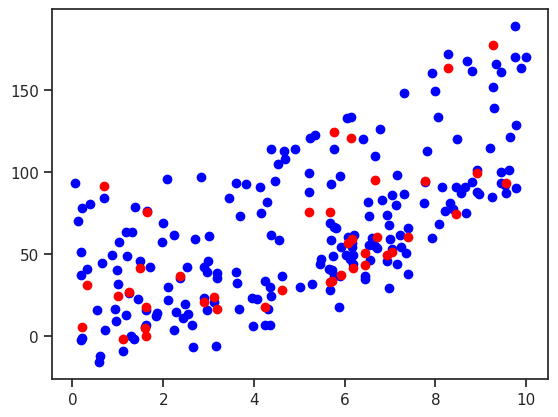

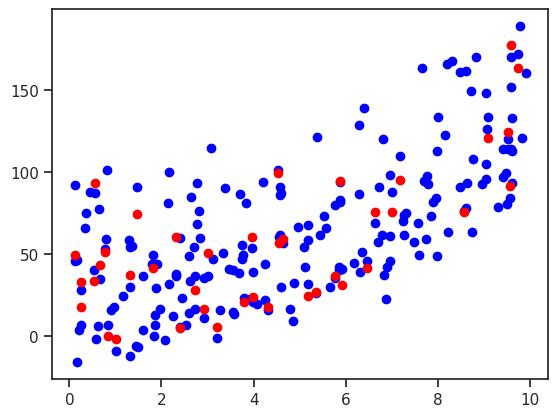

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate some sample data
np.random.seed(0)
x_1 = np.random.rand(200, 1) * 10
x_2 = np.random.rand(200, 1) * 10
a = X['train_a'] #np.array([[x_1.tolist()[i][0], x_2.tolist()[i][0]] for i in range(len(a))])
b = Y[0] #x_1**2 + x_2**2 + 10 * np.random.randn(200, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.2, random_state=0)

# Fit a polynomial regression model
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)

# Make predictions
X_test_poly = poly_features.transform(X_test)
y_pred = model.predict(X_test_poly)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot the results
plt.scatter(x_1, b, color='blue')
plt.scatter(X_test[:,0], y_pred, color='red')
plt.show()

# Plot the results
plt.scatter(x_2, b, color='blue')
plt.scatter(X_test[:,1], y_pred, color='red')
plt.show()